Testing https://satijalab.org/seurat/articles/pbmc3k_tutorial tutorial for single cell analysis. 
First, wget some data from 10x: 
wget https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
and, then unzip them: 
tar -xzvf ./pbmc3k_filtered_gene_bc_matrices.tar.gz


Explanations of files: 
a. barcodes.tsv: This file contains a list of unique barcodes, each representing a single cell. Each line corresponds to a different cell, identified by a unique barcode (e.g., AAACATACAACCAC-1).
b. genes.tsv: This file lists the genes detected in the dataset. Each line contains a gene identifier (e.g., ENSG00000243485) and the corresponding gene name (e.g., MIR1302-10).
c. matrix.mtx: This is a sparse matrix file in Matrix Market format. It contains three columns:
    The first column represents the gene index.
    The second column represents the cell index.
    The third column represents the expression count of the gene in the corresponding cell.

To find a gene: 
grep -n "FAM138A" genes.tsv 
This return a line number with is the index. 

In [52]:
library(dplyr)
library(patchwork)
library(Seurat)

# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "/workspaces/ATAi/test/single_cell/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
# pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [53]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [56]:
# Access the raw count matrix for Seurat v5 objects
counts_matrix <- GetAssayData(pbmc, slot = "counts")

# View a small portion of the counts matrix (first 10 genes and first 5 samples)
head(counts_matrix[, 1:5], 10)


10 x 5 sparse Matrix of class "dgCMatrix"
              AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1
AL627309.1                   .                .                .
AP006222.2                   .                .                .
RP11-206L10.2                .                .                .
RP11-206L10.9                .                .                .
LINC00115                    .                .                .
NOC2L                        .                .                .
KLHL17                       .                .                .
PLEKHN1                      .                .                .
RP11-54O7.17                 .                .                .
HES4                         .                .                .
              AAACCGTGCTTCCG-1 AAACCGTGTATGCG-1
AL627309.1                   .                .
AP006222.2                   .                .
RP11-206L10.2                .                .
RP11-206L10.9                .                .
LIN

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


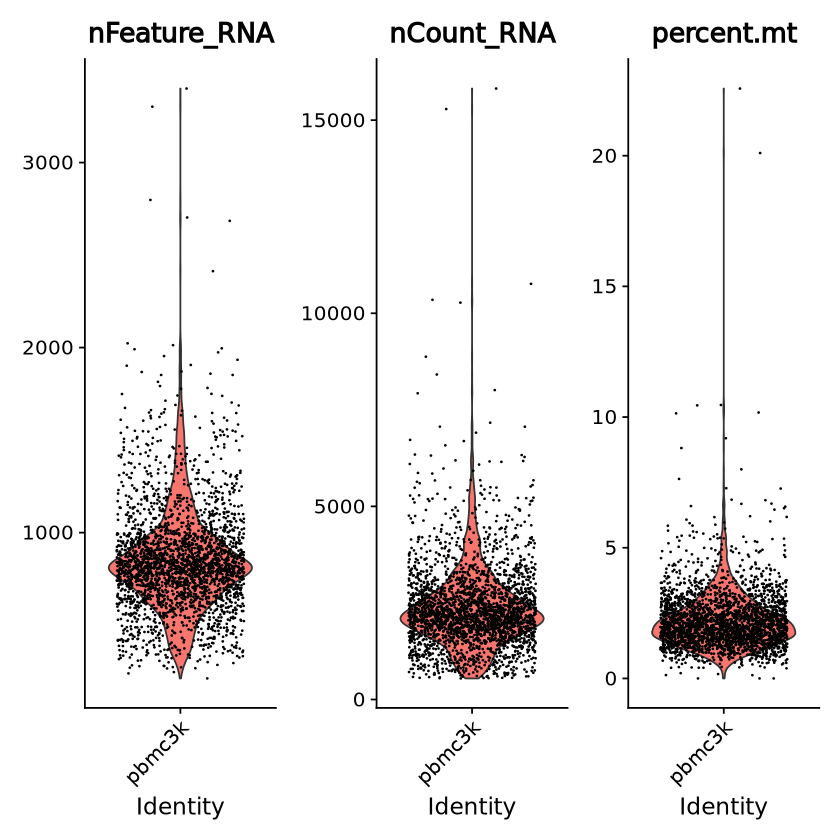

In [54]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

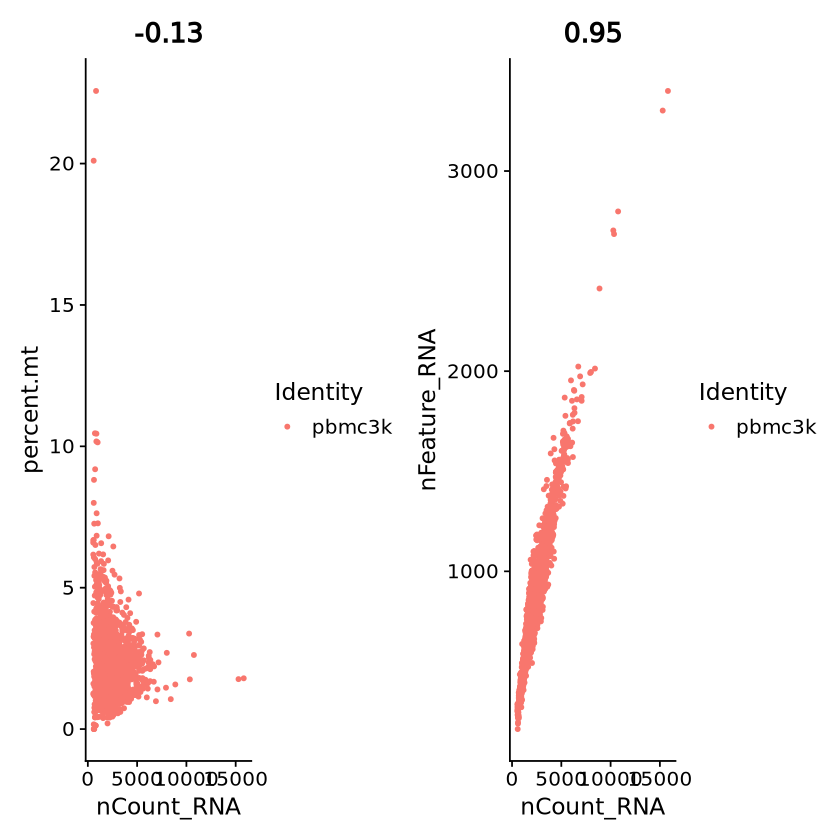

In [34]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [35]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [36]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
# pbmc <- NormalizeData(pbmc)


Normalizing layer: counts



Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


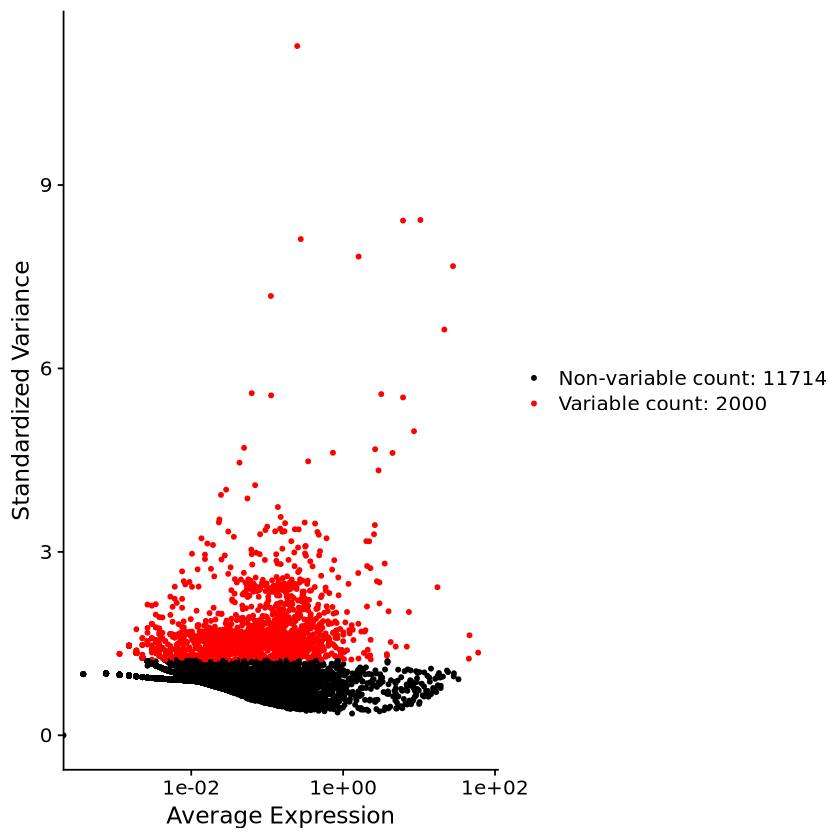

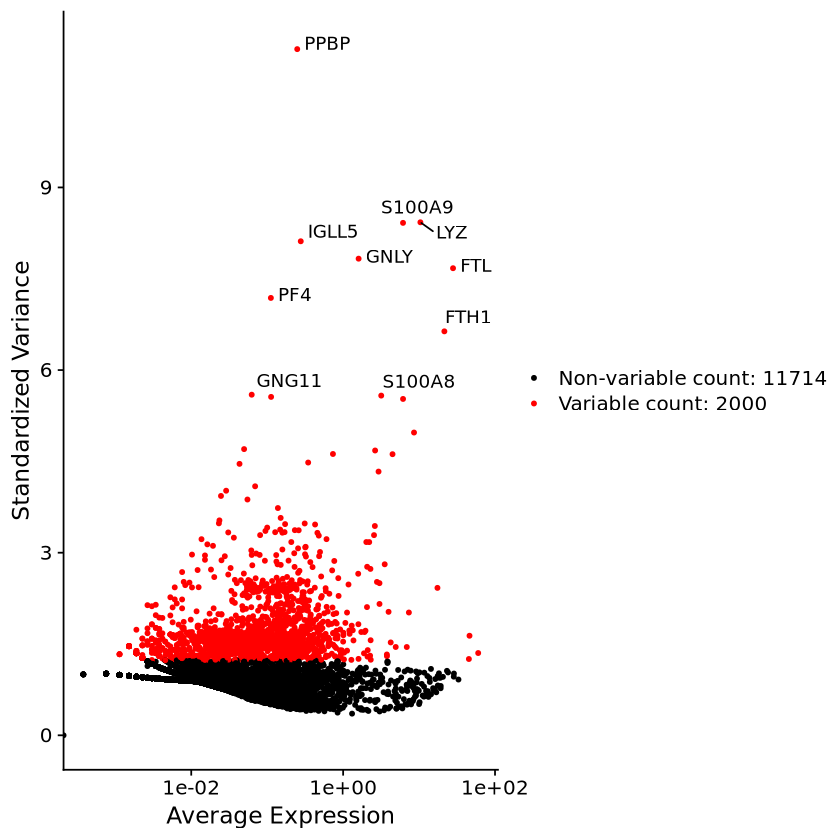

In [37]:
# Identification of highly variable features (feature selection)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)

plot1
plot2

In [38]:
# Scaling the data
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [39]:
# Perform linear dimensional reduction

pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)


PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


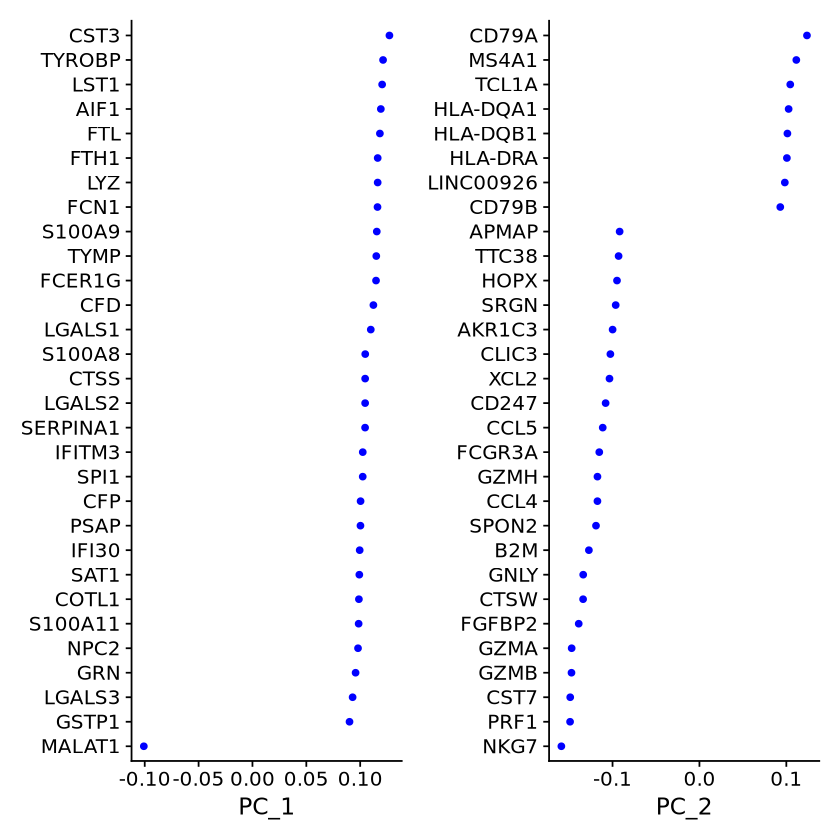

In [40]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

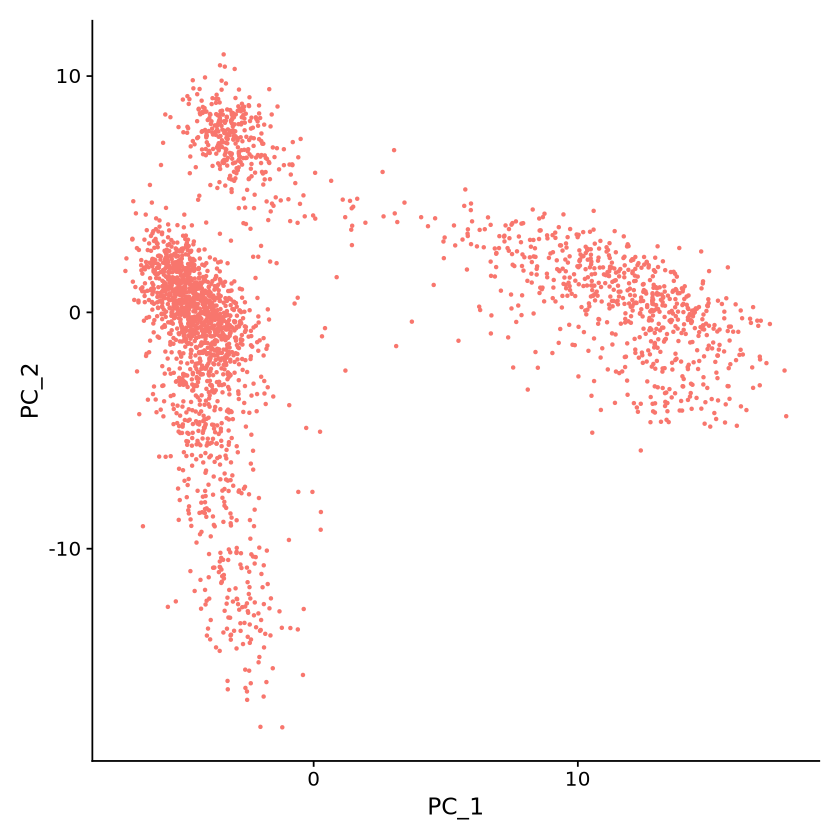

In [41]:
DimPlot(pbmc, reduction = "pca") + NoLegend()

In particular DimHeatmap() allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting cells to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.

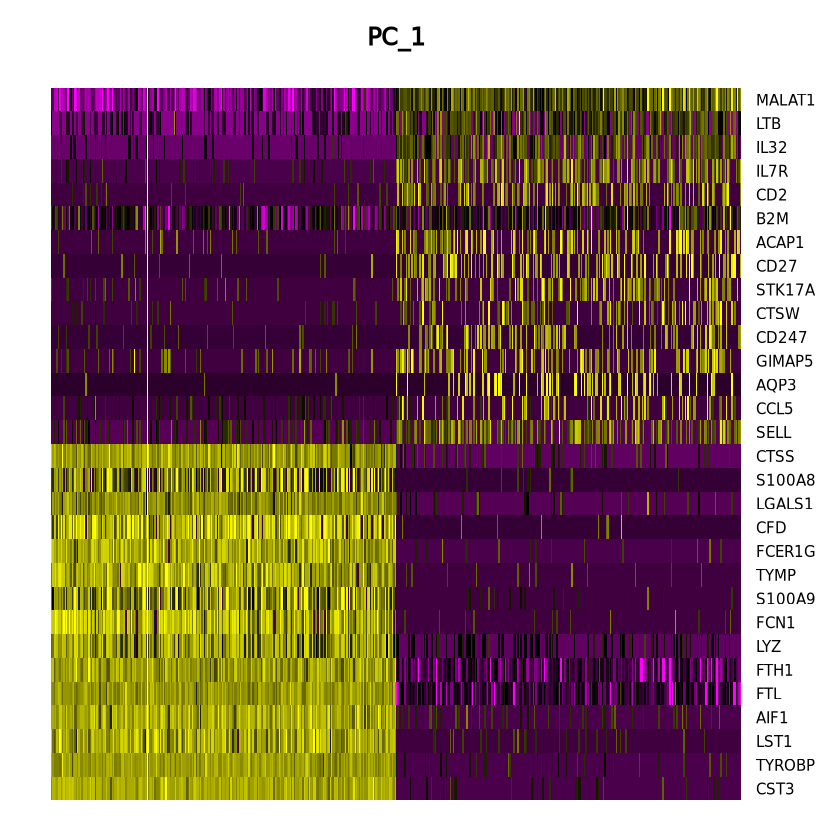

In [42]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

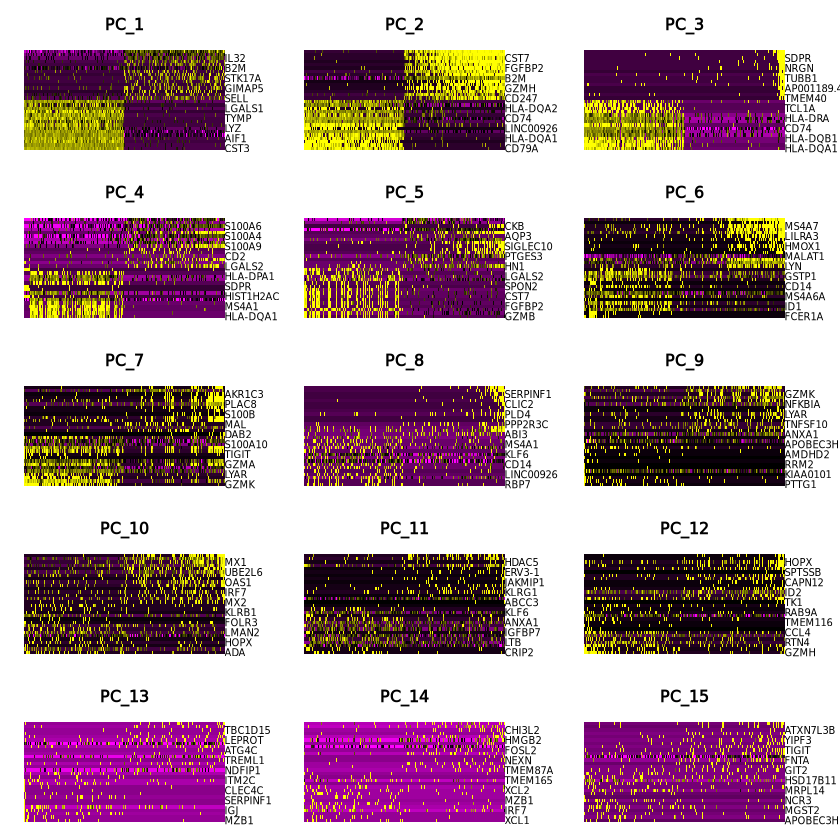

In [43]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

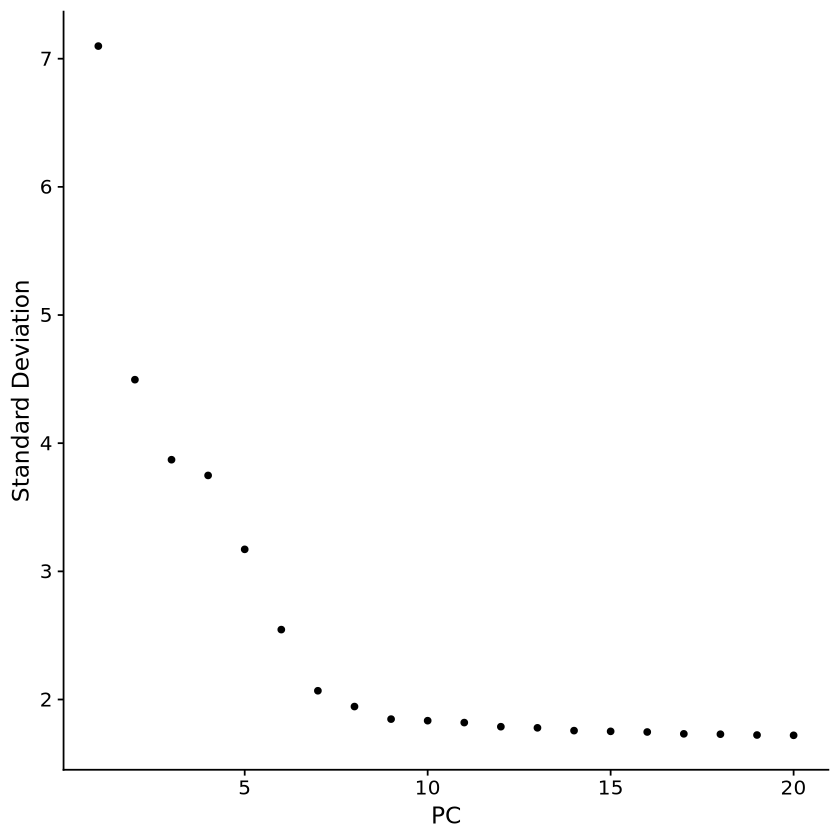

In [44]:
# Determine the ‘dimensionality’ of the dataset
ElbowPlot(pbmc)

*** Identifying the true dimensionality of a dataset – can be challenging/uncertain for the user. We therefore suggest these multiple approaches for users. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second (ElbowPlot) The third is a heuristic that is commonly used, and can be calculated instantly. In this example, we might have been justified in choosing anything between PC 7-12 as a cutoff.

We chose 10 here, but encourage users to consider the following:

Dendritic cell and NK aficionados may recognize that genes strongly associated with PCs 12 and 13 define rare immune subsets (i.e. MZB1 is a marker for plasmacytoid DCs). However, these groups are so rare, they are difficult to distinguish from background noise for a dataset of this size without prior knowledge.
We encourage users to repeat downstream analyses with a different number of PCs (10, 15, or even 50!). As you will observe, the results often do not differ dramatically.
We advise users to err on the higher side when choosing this parameter. For example, performing downstream analyses with only 5 PCs does significantly and adversely affect results.


In [45]:
# Cluster the cells
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95927

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8728
Number of communities: 9
Elapsed time: 0 seconds


In [46]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

13:13:55 UMAP embedding parameters a = 0.9922 b = 1.112

13:13:55 Read 2638 rows and found 10 numeric columns

13:13:55 Using Annoy for neighbor search, n_neighbors = 30

13:13:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:13:55 Writing NN index file to temp file /tmp/RtmpLmmPuU/file64a129711b4

13:13:55 Searching Annoy index using 1 thread, search_k = 3000

13:13:56 Annoy recall = 100%

13:13:56 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:13:57 Initializing from normalized Laplacian + noise (using RSpectra)

13:13:57 Commencing optimization for 500 epochs, with 105140 positive edges

13:14:00 Optimization finished



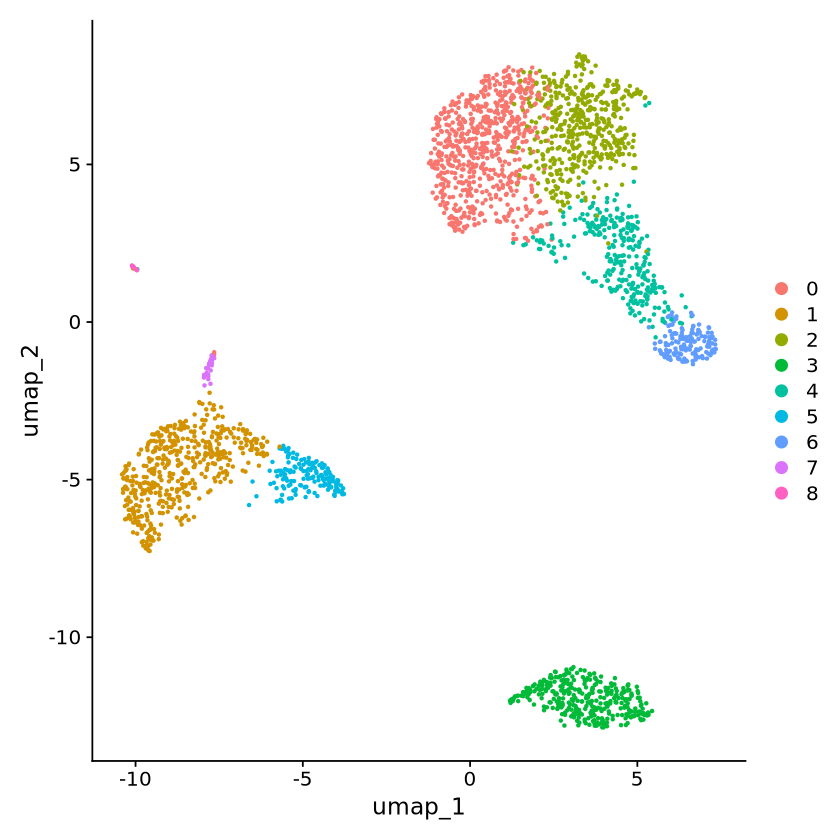

In [47]:
# Run non-linear dimensional reduction (UMAP/tSNE)

pbmc <- RunUMAP(pbmc, dims = 1:10)
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

In [48]:
# getwd()
# saveRDS(pbmc, file = "../pbmc_tutorial.rds")


In [49]:
# Finding differentially expressed features (cluster biomarkers)
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2)
head(cluster2.markers, n = 5)


In [20]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3))
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,8.246578e-205,6.794969,0.975,0.040,1.130936e-200
IFITM3,1.677613e-195,6.192558,0.975,0.049,2.300678e-191
CFD,2.401156e-193,6.015172,0.938,0.038,3.292945e-189
CD68,2.900384e-191,5.530330,0.926,0.035,3.977587e-187
RP11-290F20.3,2.513244e-186,6.297999,0.840,0.017,3.446663e-182


In [21]:
# Get the gene names of the top markers (use rownames from the marker data frame)
marker_genes <- rownames(cluster5.markers)

# Access the raw counts matrix
counts_matrix <- GetAssayData(pbmc, slot = "counts")

# Subset the counts matrix to include only the marker genes
marker_counts <- counts_matrix[marker_genes, ]

# View the first 5 genes and first 5 samples (if the matrix is large)
head(marker_counts[, 1:14], 5)


Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


  [[ suppressing 14 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



5 x 14 sparse Matrix of class "dgCMatrix"
                                         
FCGR3A        . . . 1 . . . . . 1 . . . .
IFITM3        . . . 4 . . . . . 1 . . . 6
CFD           . . . 4 . . . . . 2 . . . 2
CD68          . . . 3 . . . . . 1 . . . 3
RP11-290F20.3 . . . 1 . . . . . . . . . 1

In [22]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.746131e-112,1.206019,0.912,0.592,5.137444e-108,0,LDHB
9.571984e-88,2.397366,0.447,0.108,1.312702e-83,0,CCR7
1.154695e-76,1.064113,0.845,0.406,1.583548e-72,0,CD3D
1.122405e-54,1.043529,0.731,0.400,1.539267e-50,0,CD3E
1.354319e-51,2.136530,0.342,0.103,1.857312e-47,0,LEF1
1.942957e-47,1.198913,0.629,0.359,2.664571e-43,0,NOSIP
2.806087e-44,1.526200,0.443,0.185,3.848268e-40,0,PIK3IP1
6.269443e-43,1.985307,0.330,0.112,8.597914e-39,0,PRKCQ-AS1
1.161169e-40,2.696721,0.200,0.040,1.592427e-36,0,FHIT


In [23]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)


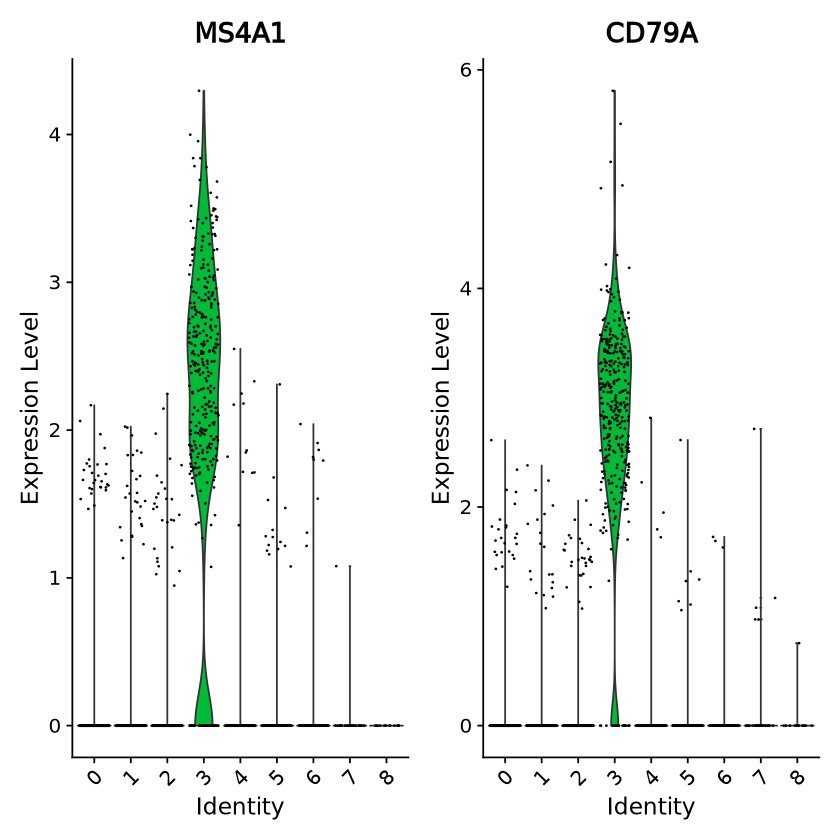

In [25]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

Warning message:
“The `slot` argument of `VlnPlot()` is deprecated as of Seurat 5.0.0.
ℹ Please use the `layer` argument instead.”


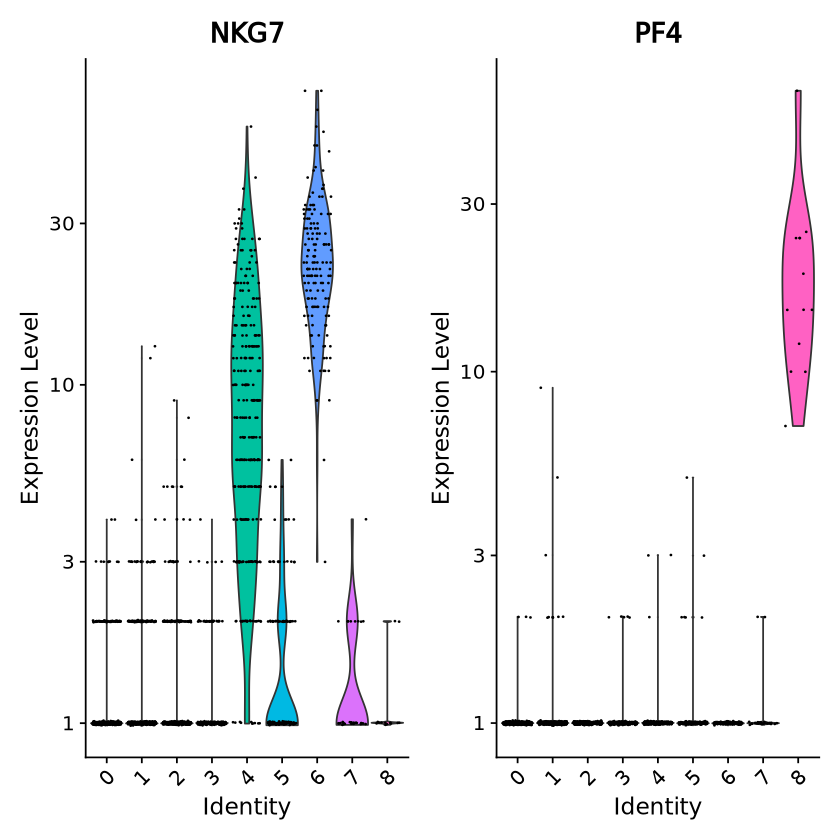

In [26]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

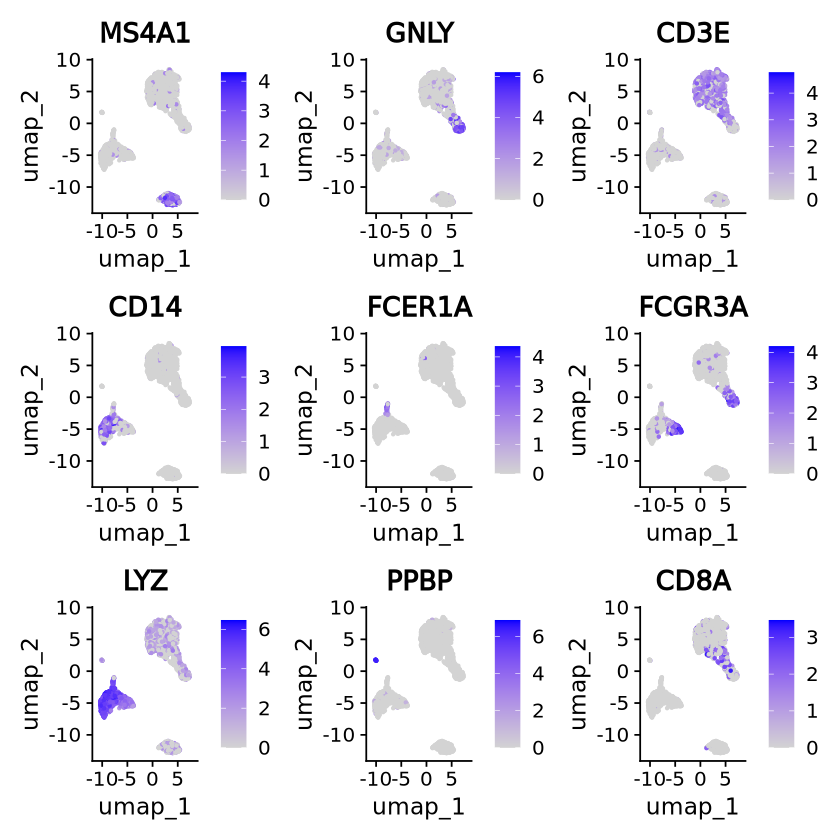

In [27]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

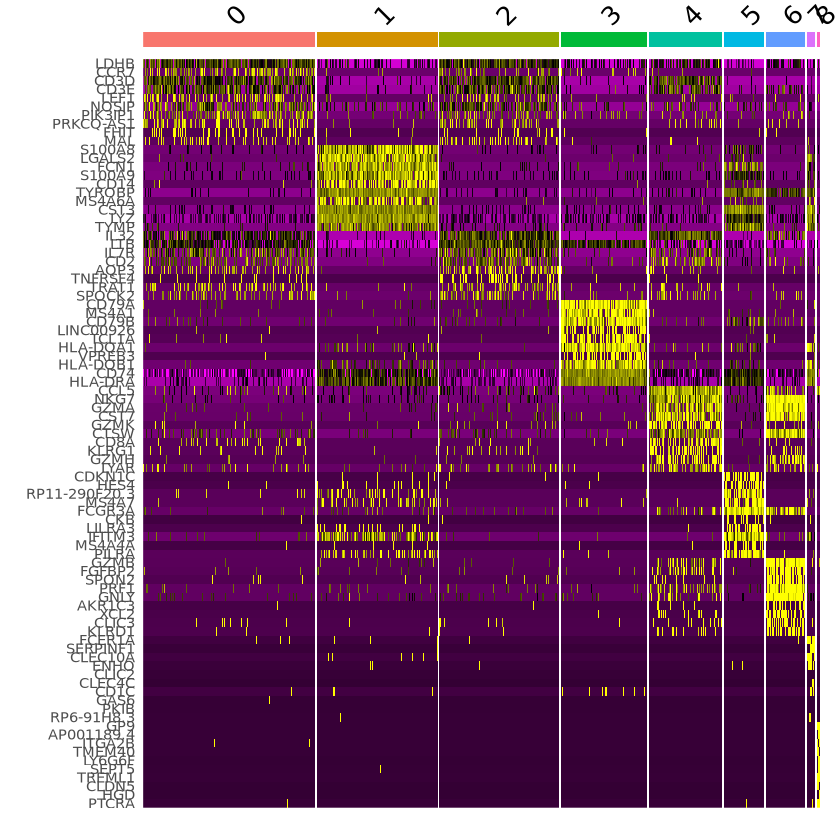

In [28]:
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

Assigning cell type identity to clusters
Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

Cluster ID	Markers	Cell Type
0	IL7R, CCR7	Naive CD4+ T
1	CD14, LYZ	CD14+ Mono
2	IL7R, S100A4	Memory CD4+
3	MS4A1	B
4	CD8A	CD8+ T
5	FCGR3A, MS4A7	FCGR3A+ Mono
6	GNLY, NKG7	NK
7	FCER1A, CST3	DC
8	PPBP	Platelet


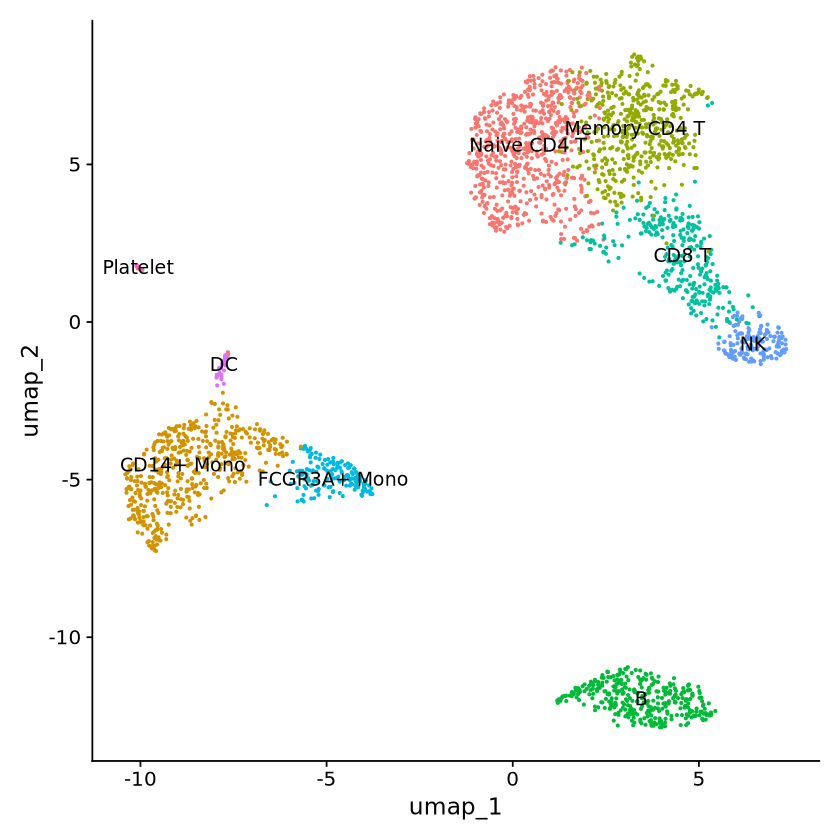

In [30]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

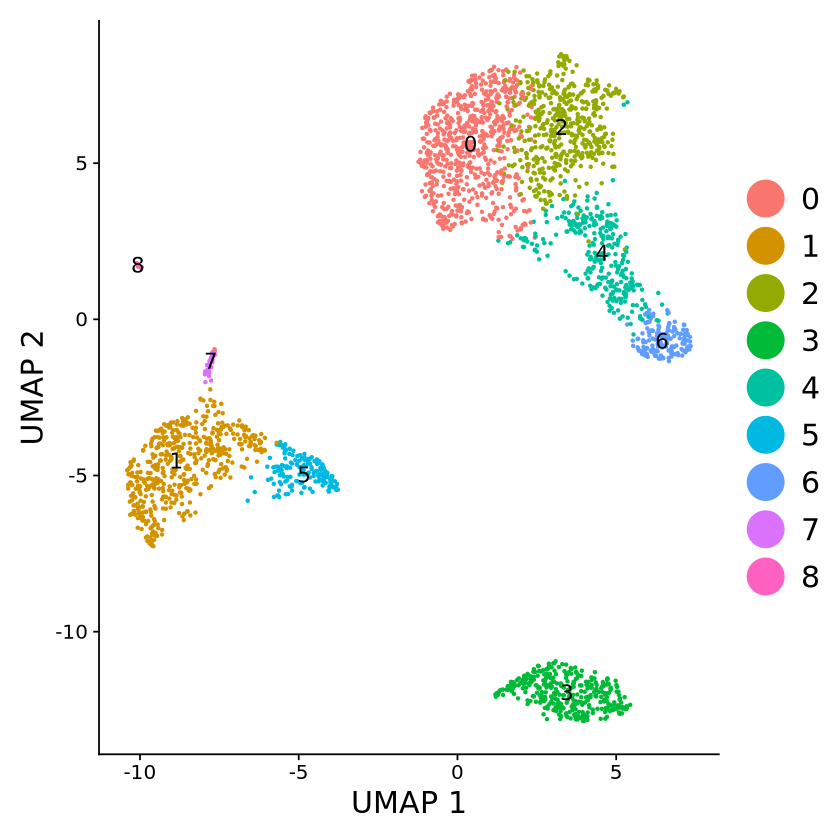

In [51]:
library(ggplot2)
plot <- DimPlot(pbmc, reduction = "umap", label = TRUE, label.size = 4.5) + xlab("UMAP 1") + ylab("UMAP 2") +
    theme(axis.title = element_text(size = 18), legend.text = element_text(size = 18)) + guides(colour = guide_legend(override.aes = list(size = 10)))
plot
# ggsave(filename = "./pbmc3k_umap.jpg", height = 7, width = 12, plot = plot, quality = 50)